# **Image Classification**
## **Traffic Sign Classification**

####*Submitted by:* 
>> **_Usama Aleem Shami_**\
>> _Reg. No. : **329894**\
>> MSCS 2020_
####*Submitted to:* 
>> **_Dr. Muhammad Moazam Fraz_**\
>> _Advanced Computer Vision (CS-893)_

## Table of Contents

1. [Connecting Google Drive and Importing Data Set](#Gdrive)
2. [Importing Packages/Modules](#Package)
3. [Defining Utility Functions](#Utils)
4. [Loading Dataset](#Load)
5. [Computing Features using HoG](#HoG)
6. [Training Model](#Train)
7. [Predicting Classes after Loading the Trained Model](#Predict)
8. [Plotting Confusion Matrices and Computing Performance Metrics](#Plot)
9. [Reporting Quantitative Results](#Quantitative)
10. [Displaying Qualitative Results](#Qualitative)

# Connecting Google Drive and Importing Data Set <a name="Gdrive"></a>

In [1]:
# Mounting Google Drive with Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Specifying Google Drive Path where Dataset is located
DATASET_PATH_GDRIVE = '/content/drive/MyDrive/ACV/Assignments/Asg1'

# Specifying Google Colab Path where Dataset is to be copied
DATASET_PATH_LOCAL = '/content/dataset'

In [3]:
# Creating desired Directory in Google Colab WorkSpace
!mkdir $DATASET_PATH_LOCAL

# Copying .zip file from Google Drive to Google Colab WorkSpace
!cp $DATASET_PATH_GDRIVE/A1_Dataset_TSC.zip $DATASET_PATH_LOCAL # MUST mention the FILE NAME after GDrive Path

print ("File Copied to Colab Workspace from GDrive, successfully!")

File Copied to Colab Workspace from GDrive, successfully!


In [4]:
# Unzipping TSC Dataset to Colab Workspace
!unzip -q $DATASET_PATH_LOCAL/A1_Dataset_TSC.zip -d $DATASET_PATH_LOCAL

print ("TSC Dataset Unzipped to Colab Workspace, successfully!")

TSC Dataset Unzipped to Colab Workspace, successfully!


#Importing Packages/Modules <a name="Package"></a>

In [5]:
import os
import cv2 as cv
import numpy as np
import matplotlib
import PIL
import joblib
import skimage
import sklearn

from PIL import Image
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from skimage import feature
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

In [6]:
# Displaying Versions of Installed Packages
!python --version 
print('OpenCV Version:', cv.__version__)
print('Numpy Version:', np.__version__)
print('Matplotlib Version:', matplotlib.__version__)
print('Pillow Version:', PIL.__version__)
print('Joblib Version:', joblib.__version__)
print('Scikit Learn Version:', sklearn.__version__)
print('Scikit Image Version:', skimage.__version__)

Python 3.7.12
OpenCV Version: 4.1.2
Numpy Version: 1.21.5
Matplotlib Version: 3.2.2
Pillow Version: 7.1.2
Joblib Version: 1.1.0
Scikit Learn Version: 1.0.2
Scikit Image Version: 0.18.3


#Defining Utility Functions <a name="Utils"></a>

In [8]:
# Function to Load Images
def loadPPMImages(def_path, num_classes, DatasetType, x, y):
  """
    This function loads images by taking directory's path, no. of classes, folder name and dimensions to resize 
    images as its input parameters and returns the images along with their labels.
    # Args:
    #   def_path: a string containing the path of direcotry containing the dataset
    #   num_classes: an integer depicting the total number of classes
    #   DatasetType: a string depicting the folder name depending upon its type i.e. Train or Test
    #   x,y: integer values for resizing image dimensions to (x,y)
    # Returns:
    #   two numpy arrays containing data (images) and their labels respectively
    
  """
  data = []
  labels = []
  DatasetType
  for i in tqdm(range(num_classes)):
    path = os. path.join(def_path,DatasetType,str(i+1)) 
    images = os.listdir(path) 
    for a in images: 
      try: 
        image = Image.open(path + '/'+ a).convert("L").resize((x,y)) 
        image = np.array(image) 
        data.append(image) 
        labels.append(i+1) 
      except: 
        print("Error loading image")
  return data, labels


# Function to Compute HoG Features
def computeHOG(image):
  """
    This function computes Histogram of Oriented Gradients of the input image and returns the feature vector
    along with the image showing the Oriented Gradients.
  """
  (H, hogImage) = feature.hog(image, orientations = 9,
                                pixels_per_cell  = (8, 8), cells_per_block  = (2, 2), transform_sqrt = True,
                                block_norm  = 'L1' , visualize = True)
  return (H, hogImage)


# Function to Construct and Plot Confusion Matrix
def plotConfusionMatrix(y_true, y_pred, classes,
                          normalize = False,
                          title = None,
                          cmap = plt.cm.Blues):
  """
    This function constructs Confusion Matrix by taking True and Predicted values, and an array of class labels 
    as its input parameters
  """ 
  if not title:
      if normalize:
          title = 'Normalized Confusion Matrix'
      else:
          title = 'Confusion Matrix without Normalization'

  cm = confusion_matrix(y_true, y_pred)
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized Confusion Matrix")
  else:
      print('Confusion Matrix without Normalization')

  print(cm)

  fig, ax = plt.subplots()
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax)
  ax.set(xticks=np.arange(cm.shape[1]),
          yticks=np.arange(cm.shape[0]),
          xticklabels=classes, yticklabels=classes,
          title=title,
          ylabel='True label',
          xlabel='Predicted label')

  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),
                  ha="center", va="center",
                  color="white" if cm[i, j] > thresh else "black")
  fig.tight_layout()
  return ax

# Function to Plot Confusion Matrices (With and Without Normalization)
def plotConfusions(true, predictions):
  """
    This function plots the Confusion Matrices, with and without Normalizing the scores.
  """ 
  np.set_printoptions(precision = 2)

  class_names = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]
  plotConfusionMatrix(true, predictions, classes = class_names,
                    title='Confusion Matrix without normalization')

  plotConfusionMatrix(true, predictions, classes = class_names, normalize = True,
                    title='Normalized Confusion Matrix')

  plt.show()

# Function to Compute Performance Metrics
def findPerformanceMetrics(true, predictions):
  """
    This function prints the Performance Metrics of a Model by taking True and Predicted values as 
    its imput parameters
  """ 
  print('-----------------------')
  print("Accuracy Score:  %0.3f"% accuracy_score(true, predictions))
  print("Precision Score: %0.3f"% precision_score(true, predictions,average = 'micro'))
  print("Recall Score:    %0.3f"% recall_score(true, predictions, average = 'micro'))
  print("F1 Score:        %0.3f"% f1_score(true, predictions, average = 'micro'))
  print('-----------------------')
  return accuracy_score

#Loading Dataset <a name="Load"></a>

In [9]:
# Defining Path for Dataset
cur_path = DATASET_PATH_LOCAL + '/A1_Dataset_TSC'

# Loading Training Images
dataTrain , labelTrain = loadPPMImages(cur_path, 10, 'Train', 30, 30)
print("Training Images loaded successfully!")

dataTrain = np.array(dataTrain)
labelTrain = np.array(labelTrain)
print(dataTrain.shape, labelTrain.shape)

# Loading Testing Images
dataTest , labelTest = loadPPMImages(cur_path, 10, 'Test', 30, 30)
print("Testing Images loaded successfully!")

dataTest = np.array(dataTest)
labelTest = np.array(labelTest)
print(dataTest.shape, labelTest.shape)

  0%|          | 0/10 [00:00<?, ?it/s]

Training Images loaded successfully!
(800, 30, 30) (800,)


  0%|          | 0/10 [00:00<?, ?it/s]

Testing Images loaded successfully!
(200, 30, 30) (200,)


#Computing Features using HoG <a name="HoG"></a>

In [10]:
# dataTrain --> contains resized training images
# labelTrain --> contains labels of training images
# dataTest --> contains resized testing images
# labelTest --> contains labels of testing images


global hogTrain #HOG Feature Vectors for Training Images
global hogTest #HOG Feature Vectors for Testing Images

hogTrain = []
hogImgTrain = []

# Computing the HOG features for Training Dataset (Images)
for i in tqdm(range(0,len(dataTrain))):
  (h_vector, h_image) = computeHOG(dataTrain[i])
  hogTrain.append(h_vector)
  hogImgTrain.append(h_image)
print("HOG computed for Training Images successfully! \n")

hogTest = []
hogImgTest = []

# Computing the HOG features for Testing Dataset (Images)
for i in tqdm(range(0,len(dataTest))):
  (h_vector, h_image) = computeHOG(dataTest[i])
  hogTest.append(h_vector)
  hogImgTest.append(h_image)
print("HOG computed for Testing Images successfully!")

  0%|          | 0/800 [00:00<?, ?it/s]

HOG computed for Training Images successfully! 



  0%|          | 0/200 [00:00<?, ?it/s]

HOG computed for Testing Images successfully!


#Training Model <a name="Train"></a>

In [11]:
# Training Linear SVC (SVM Classifier)
clf1 = LinearSVC().fit(hogTrain, labelTrain)
print("SVC training completed!")

# Saving Trained Model (Linear SVC)
filename1 = DATASET_PATH_LOCAL + '/Linear_SVC.joblib'
joblib.dump(clf1, filename1)
print("Linear Support Vector Classifier Model saved!")

SVC training completed!
Linear Support Vector Classifier Model saved!


#Predicting Classes after Loading the Trained Model <a name="Predict"></a>

In [12]:
# Loading Trained Linear SVC for Predicting Labels
svc = joblib.load(filename1)
labelPredictedSVC = svc.predict(hogTest)
print("Labels Predicted for Testing Dataset by Linear SVC \n")

print("Comparing Predicted and Actual labels\n")
print(np.transpose(labelPredictedSVC[0:200]),'\n')
print(np.transpose(labelTest[0:200]),'\n')

Labels Predicted for Testing Dataset by Linear SVC 

Comparing Predicted and Actual labels

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  2  3
  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10] 

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5 

#Plotting Confusion Matrices and Computing Performance Metrics <a name="Plot"></a>

Confusion Matrix without Normalization
[[20  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0]
 [ 0  1 19  0  0  0  0  0  0  0]
 [ 0  0  0 20  0  0  0  0  0  0]
 [ 0  0  0  0 20  0  0  0  0  0]
 [ 0  0  0  0  0 20  0  0  0  0]
 [ 0  0  0  0  0  0 20  0  0  0]
 [ 0  0  0  0  0  0  0 20  0  0]
 [ 0  0  0  0  0  0  0  0 20  0]
 [ 0  0  0  0  0  0  0  0  0 20]]
Normalized Confusion Matrix
[[1.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.05 0.95 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   1.  ]]


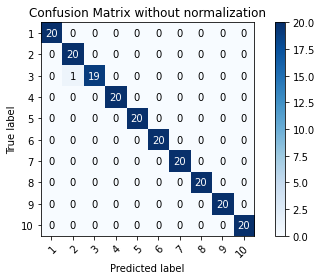

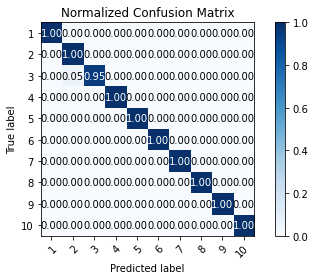

Confusion Matrices plotted! 

-----------------------
Accuracy Score:  0.995
Precision Score: 0.995
Recall Score:    0.995
F1 Score:        0.995
-----------------------

Performance Metrics calculated! 



In [13]:
plotConfusions(labelTest, labelPredictedSVC)
print("Confusion Matrices plotted! \n")

findPerformanceMetrics(labelTest, labelPredictedSVC)
print("\nPerformance Metrics calculated! \n")

#Reporting Quantitative Results <a name="Quantitative"></a>

In [14]:
# Showing Performance Metrics for our Model
class_names = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]
print(classification_report(labelTest, labelPredictedSVC, target_names = class_names))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        20
           2       0.95      1.00      0.98        20
           3       1.00      0.95      0.97        20
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00        20
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00        20
           8       1.00      1.00      1.00        20
           9       1.00      1.00      1.00        20
          10       1.00      1.00      1.00        20

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200



#Displaying Qualitative Results <a name="Qualitative"></a>

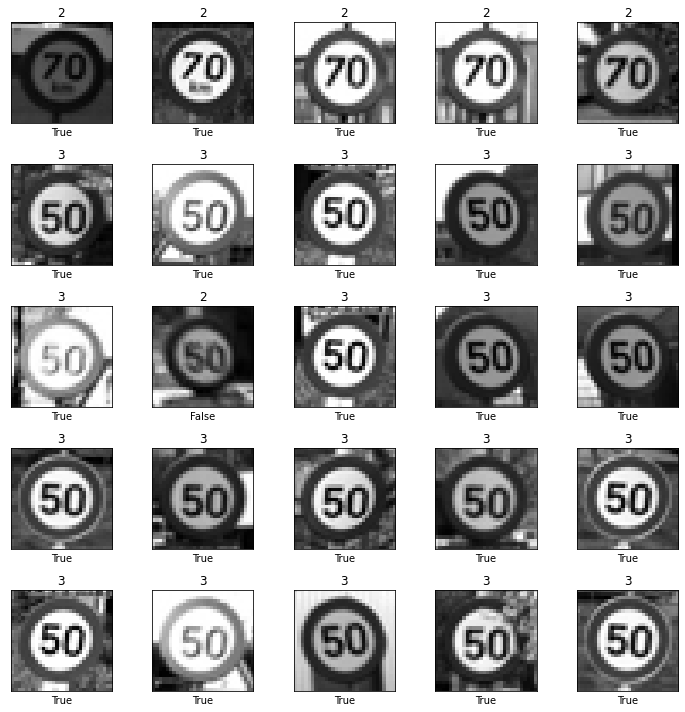

In [15]:
# Displaying Images highlighting Correct and Incorrect Predictions

rows = 5
columns = 5
startIndex = 35

fig, ax = plt.subplots(nrows = rows, ncols = columns, sharex = True, sharey = True, figsize=(10,10))
for i in range(rows):
    for j in range(columns):
        img = dataTest[startIndex]
        ax[i][j].imshow(img, cmap ='gray')
        ax[i][j].set_title(labelPredictedSVC[startIndex])
        if labelPredictedSVC[startIndex] == labelTest[startIndex]:
          ax[i][j].set_xlabel('True') #Flag for Correct Predition
        else:
          ax[i][j].set_xlabel('False') #Flag for Wrong Predition
        startIndex += 1
        
ax[0][0].set_yticks([])
ax[0][0].set_xticks([])
plt.tight_layout()
plt.show()